## Plate 2

In [1]:
import ast
import itertools
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import toml
import umap

In [2]:
# Parameters
cell_type = "PBMC"
sample = False

In [3]:
# read in toml file

# set up the path
toml_path = pathlib.Path("../utils/params.toml")
# read in the toml file
params = toml.load(toml_path)
list_of_treatments = params["list_of_treatments"]["treatments"]
print(len(list_of_treatments))
print(list_of_treatments)

15
['DMSO_0.100_%_DMSO_0.025_%', 'Thapsigargin_1.000_uM_DMSO_0.025_%', 'Thapsigargin_10.000_uM_DMSO_0.025_%', 'H2O2_100.000_uM_DMSO_0.025_%', 'H2O2_100.000_nM_DMSO_0.025_%', 'Flagellin_0.100_ug_per_ml_DMSO_0.025_%', 'Flagellin_1.000_ug_per_ml_DMSO_0.025_%', 'LPS_0.010_ug_per_ml_DMSO_0.025_%', 'LPS_0.100_ug_per_ml_DMSO_0.025_%', 'LPS_1.000_ug_per_ml_DMSO_0.025_%', 'LPS_10.000_ug_per_ml_DMSO_0.025_%', 'LPS_100.000_ug_per_ml_DMSO_0.025_%', 'LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%', 'LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%', 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%']


In [4]:
# Set path to parquet file
path = pathlib.Path(f"../../data/{cell_type}_preprocessed_sc_norm.parquet").resolve(
    strict=True
)
# Read in parquet file
df = pq.read_table(path).to_pandas()

In [5]:
# subsample the data
n = 100
# Assuming df is your DataFrame and 'column_name' is the column you want to subsample by
df = df.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
    lambda x: x.sample(n)
)

In [6]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])
# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [7]:
# set umap parameters
umap_params = umap.UMAP(
    n_components=2,
    spread=1.1,
    min_dist=0.8,
    init="random",
    metric="cosine",
    random_state=0,
    n_jobs=-1,
)

In [8]:
# fit and transform data for umap
proj_2d = umap_params.fit_transform(df_values)
# add umap coordinates to dataframe of metadata and raw data
df_values["umap_1"] = proj_2d[:, 0]
df_values["umap_2"] = proj_2d[:, 1]

/projects/mlippincott@xsede.org/software/anaconda/envs/Interstellar_python/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df_descriptive[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
]

In [10]:
# randomize the rows of the dataframe to plot the order of the data evenly
df_values = df_values.sample(frac=1, random_state=0)

if sample:
    df_values_path = pathlib.Path(
        f"./results/{cell_type}_umap_values_morphology_sample_{n}.parquet"
    )
else:
    df_values_path = pathlib.Path(
        f"./results/{cell_type}_umap_values_morphology_all_cells.parquet"
    )
# if path does not exist create it
df_values_path.parent.mkdir(parents=True, exist_ok=True)
# save the dataframe as a parquet file
df_values.to_parquet(df_values_path)

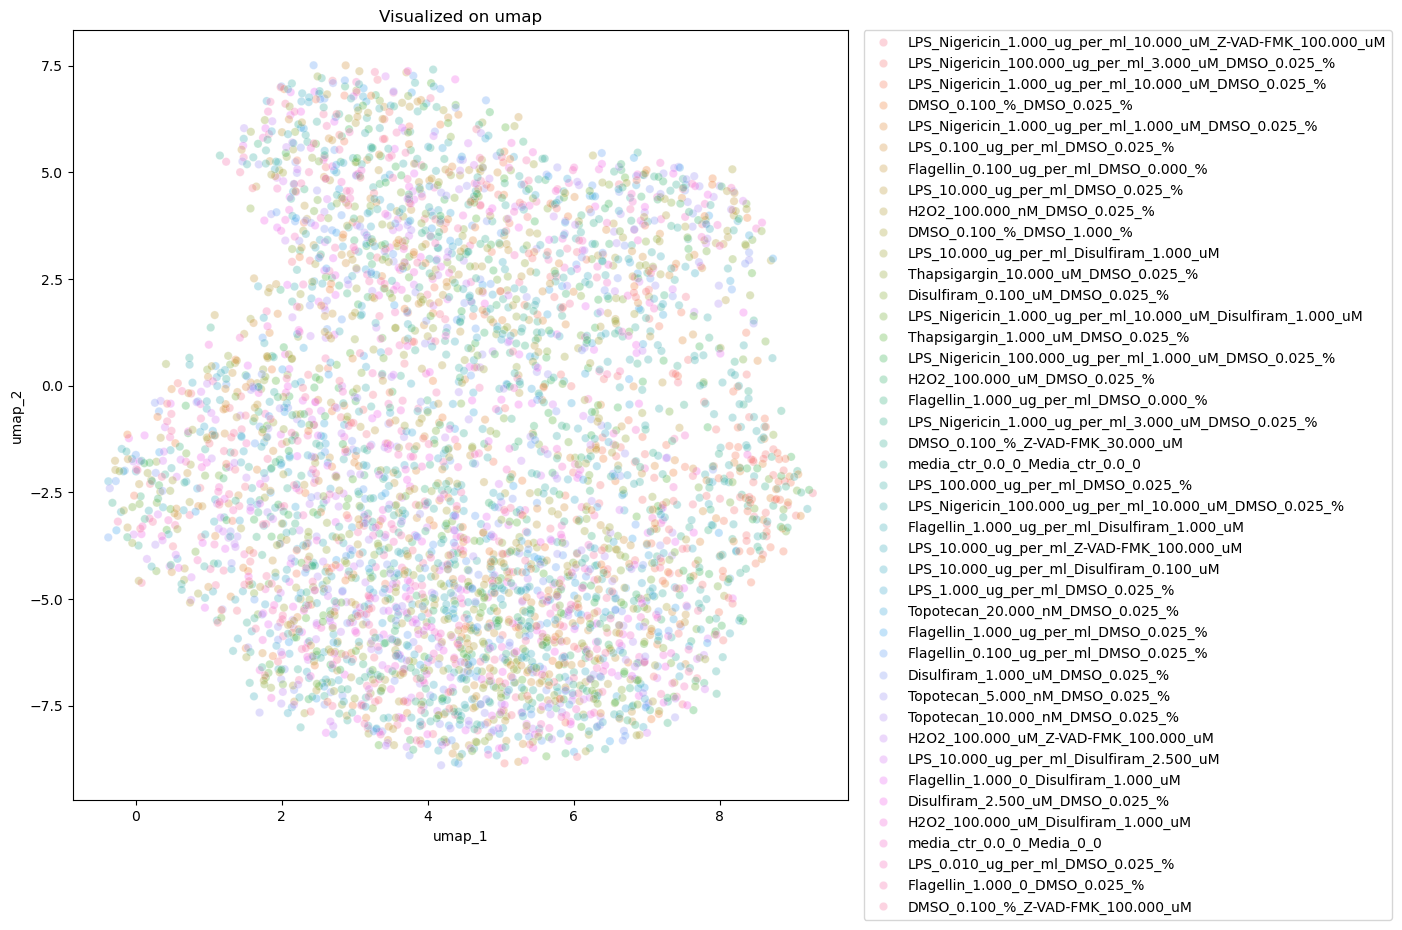

In [11]:
# Figure Showing UMAP of Clusters vs Treatment
# figure size set
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_values,
    x="umap_1",
    y="umap_2",
    hue="oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
    legend="full",
    alpha=0.3,
)
plt.title("Visualized on umap")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()